In [1]:
import pandas as pd

proteins = pd.read_csv("../data/enzymes/proteins.csv")
proteins = proteins[proteins["#Peptides"]>=50]
proteins["Accession"] = proteins["Accession"].apply(lambda x: x.split("|")[1].split("_")[0])
proteins

,Protein Group,Protein ID,Accession,-10lgP,Coverage (%),Coverage (%) cht1,Coverage (%) cht2,Coverage (%) cht3,Coverage (%) cht4,Coverage (%) cht5,...,#Spec trp4,#Spec trp5,#Spec trp6,#Spec trp7,#Spec trp8,#Spec trp9,#Spec trp10,PTM,Avg. Mass,Description
0,2,7,AHNK,404.88,67,2,3,3,3,3,...,295,316,245,267,310,356,349,NaN,629114,Neuroblast differentiation-associated protein ...
1,7,3,CH60,379.98,94,55,71,71,64,69,...,73,89,78,79,87,115,110,NaN,61055,60 kDa heat shock protein mitochondrial OS=Ho...
2,10,23,BIP,355.27,93,50,69,66,68,64,...,77,82,72,75,87,89,91,NaN,72333,Endoplasmic reticulum chaperone BiP OS=Homo sa...
3,44,11,NPM,349.90,81,56,59,64,64,64,...,24,30,23,24,25,31,30,NaN,32575,Nucleophosmin OS=Homo sapiens OX=9606 GN=NPM1 ...
4,3,254,H2B1M,349.30,92,64,69,69,69,71,...,88,86,67,80,66,117,90,NaN,13989,Histone H2B type 1-M OS=Homo sapiens OX=9606 G...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,808,725,NOMO2,166.03,35,0,0,1,1,2,...,9,9,8,9,8,11,13,NaN,139439,Nodal modulator 2 OS=Homo sapiens OX=9606 GN=N...
747,636,806,HSP74,164.13,45,3,4,5,6,6,...,10,10,8,8,12,10,11,NaN,94331,Heat shock 70 kDa protein 4 OS=Homo sapiens OX...
760,616,937,SYEP,162.21,31,2,2,2,2,2,...,12,13,8,6,16,15,16,NaN,170590,Bifunctional glutamate/proline--tRNA ligase OS...
761,645,821,ATD3A,162.19,50,4,3,6,6,8,...,11,9,7,9,11,13,12,NaN,71369,ATPase family AAA domain-containing protein 3A...


In [2]:
def remove_ends(peptide):
    if peptide[1] == '.':
        peptide = peptide[2:]
    if peptide[-2] == '.':
        peptide = peptide[:-2]
    return peptide


df = pd.read_csv("../data/enzymes/protein-peptides.csv")

df["Protein Accession"] = df["Protein Accession"].apply(lambda x: x.split("|")[1].split("_")[0])

df = df[df["Protein Accession"].isin(proteins["Accession"])]

df["Peptide"] = df["Peptide"].apply(remove_ends)

samples = [col for col in df.columns if col.startswith("Area")]
df.set_index(["Protein Accession", "Peptide"], inplace=True)
df = df[samples]

import numpy as np

df = df.apply(np.log2).fillna(0).replace(-np.inf, 0)
df

Area cht1  Area cht2  \
Protein Accession Peptide                                             
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK        0.0        0.0   
                  HELTEISNVDVETQSGK                  0.0        0.0   
                  IKGDVPSVGLEGPDVDLQGPEAK            0.0        0.0   
                  GPHVDVSGPDIDIEGPEGK                0.0        0.0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK          0.0        0.0   
...                                                  ...        ...   
AHNK2             TRLEGDL                            0.0        0.0   
                  EATEVTLK                           0.0        0.0   
                  GDLKNTDISIEPPS                     0.0        0.0   
                  MISSSVNVL                          0.0        0.0   
                  LQMPSFK                            0.0        0.0   

                                               Area cht3  Area cht4  \
Protein Accession Peptide                                             
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK        0.0        0.0   
                  HELTEISNVDVETQSGK                  0.0        0.0   
                  IKGDVPSVGLEGPDVDLQGPEAK            0.0        0.0   
                  GPHVDVSGPDIDIEGPEGK                0.0        0.0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK          0.0        0.0   
...                                                  ...        ...   
AHNK2             TRLEGDL                            0.0        0.0   
                  EATEVTLK                           0.0        0.0   
                  GDLKNTDISIEPPS                     0.0        0.0   
                  MISSSVNVL                          0.0        0.0   
                  LQMPSFK                            0.0        0.0   

                                               Area cht5  Area cht6  \
Protein Accession Peptide                                             
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK        0.0        0.0   
                  HELTEISNVDVETQSGK                  0.0        0.0   
                  IKGDVPSVGLEGPDVDLQGPEAK            0.0        0.0   
                  GPHVDVSGPDIDIEGPEGK                0.0        0.0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK          0.0        0.0   
...                                                  ...        ...   
AHNK2             TRLEGDL                            0.0        0.0   
                  EATEVTLK                           0.0        0.0   
                  GDLKNTDISIEPPS                     0.0        0.0   
                  MISSSVNVL                          0.0        0.0   
                  LQMPSFK                            0.0        0.0   

                                               Area cht7  Area cht8  \
Protein Accession Peptide                                             
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK        0.0        0.0   
                  HELTEISNVDVETQSGK                  0.0        0.0   
                  IKGDVPSVGLEGPDVDLQGPEAK            0.0        0.0   
                  GPHVDVSGPDIDIEGPEGK                0.0        0.0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK          0.0        0.0   
...                                                  ...        ...   
AHNK2             TRLEGDL                            0.0        0.0   
                  EATEVTLK                           0.0        0.0   
                  GDLKNTDISIEPPS                     0.0        0.0   
                  MISSSVNVL                          0.0        0.0   
                  LQMPSFK                            0.0        0.0   

                                               Area cht9  Area cht10  ...  \
Protein Accession Peptide                                             ...   
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK        0.0         0.0  ...   
                  HELTEISNVDVETQSGK                  0.0         0.0  ...   
                  IKGDVPSVGLEGPDVDLQGPEAK  

In [3]:
samples_split = [s.split(" ")[1] for s in samples]

import re

pattern = r'[0-9]'

groups = [re.sub(pattern, '', s) for s in samples_split]

design = pd.DataFrame({"sample":samples_split, "group":groups})
design.to_csv("../data/enzymes/design.csv")

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


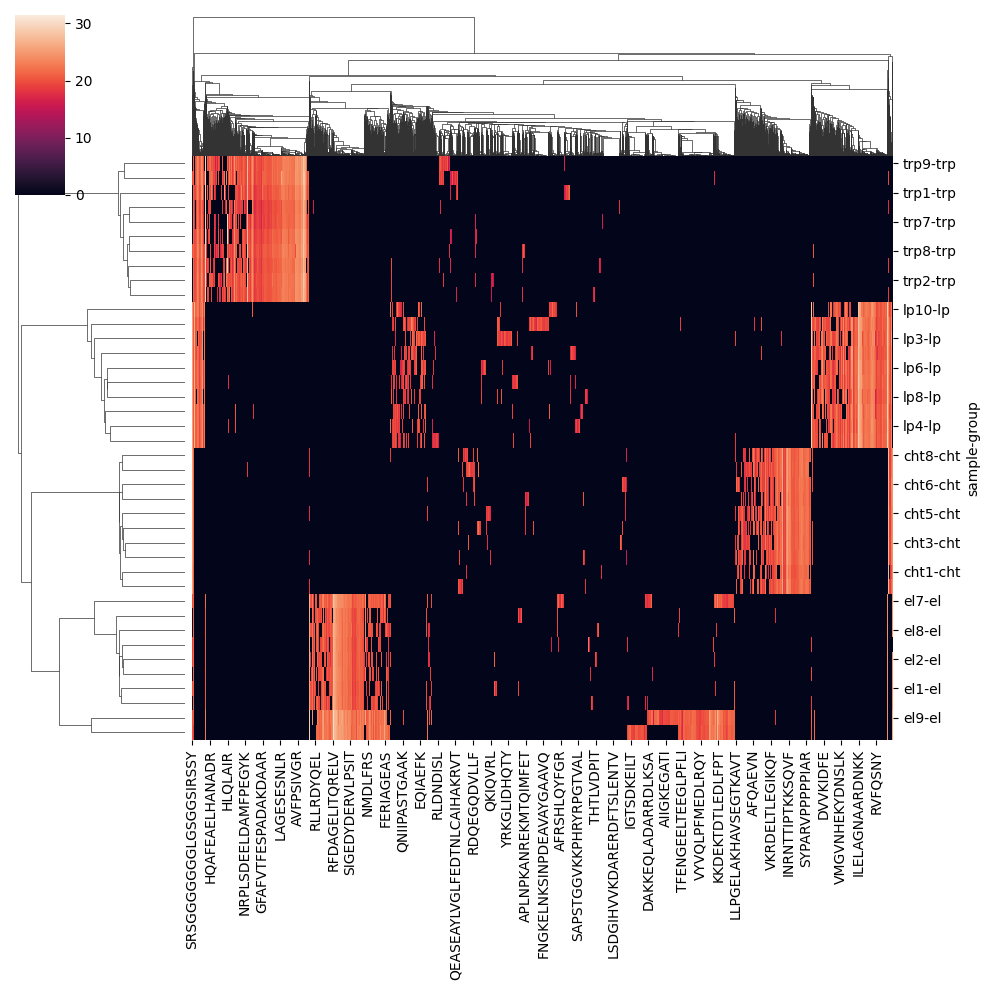

In [4]:
import seaborn as sns

sq = df.reset_index().drop(columns="Protein Accession").rename(columns={"Peptide":"sample"}).set_index("sample").T
sq.index = [s.split(" ")[1] for s in sq.index]
sq = sq.merge(design, left_index=True, right_on="sample").set_index(["sample","group"])

sns.clustermap(sq)

In [5]:
data_dict = {}

for sample in samples:
    sample_data = df[sample].dropna().reset_index()
    protein_dict = {}
    for protein in sample_data["Protein Accession"].unique():
        protein_data = sample_data[sample_data["Protein Accession"] == protein]
        peptide_dict = {}

        for i, row in protein_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


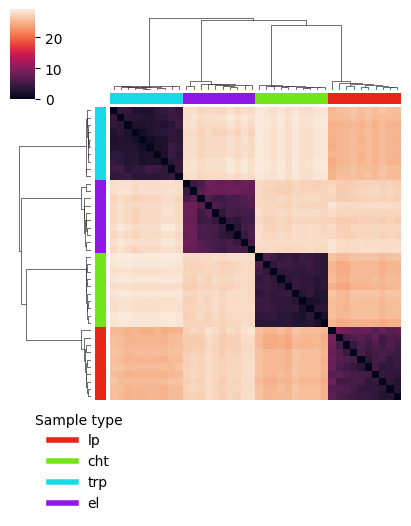

In [6]:


from disassembly.util import KL, normalize_dict
from disassembly.estimate_parameters import compare



protein = "ACTB"

comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

import seaborn as sns
from matplotlib.lines import Line2D

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)

g = sns.clustermap(
    comps_df,
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l) for l, c in zip(lut.keys(), lut.values())
]
g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [7]:
df = df.rename(columns={s1:s2 for s1,s2 in zip(samples, samples_split)})


In [8]:
df.to_csv("../data/enzymes/processed.csv")